# Initialization

Related imports and setup.

This notebook demonstrates how to use a basic multiagent reinforcement learning algorithm to tackle the CityLearn 2022 problem, with an implementation of CommNet and centralised DeepDeterministicPolicyGradient. I assume basic reader familiarity with RL concepts.

For more information, 


CommNet: S Sukhbaata, Learning Multiagent Communication with Backpropagation, https://arxiv.org/abs/1605.07736

DDPG: TP Lillicrap, Continuous Control with Deep Reinforcement Learning, https://arxiv.org/abs/1509.02971

In [1]:
import numpy as np
import math
import time, random, typing, cProfile, traceback
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import pandas as pd

from citylearn.citylearn import CityLearnEnv

class Constants:
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'

def action_space_to_dict(aspace):
    """ Only for box space """
    return { "high": aspace.high,
             "low": aspace.low,
             "shape": aspace.shape,
             "dtype": str(aspace.dtype)
    }

def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info.values())
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations }
    return obs_dict

env = CityLearnEnv(schema=Constants.schema_path)
obs_dict = env_reset(env)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Algorithm

A very high level and not very rigorous overview.

### DDPG

A reinforcement learning algorithm combining insights from 3 seperate ideas.

I learnt a lot during implementation from Chris Yoon's article - 
https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b

#### Actor Critic Framework

A reinforcement learning framework using two seperate networks, answering two different questions.
 
1. **Critic**: How good is taking an action $A$ in state $S$? This network is trained by previous observations of the environment.
2. **Actor**: Given the state of the current environment, what is the best action to take? We can train this with the critic acting as a guide.

#### Deterministic Policy Gradient

A special case of the policy gradient concerning a *deterministic* policy, which is a policy that outputs a single action rather than a distribution. This (counterintuitively) is a method that helps generalize DQN to *continuous* action spaces, and also allows us to utilize the gradient of the critic network during policy training.

A good read is below.

https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#what-is-policy-gradient


#### Deep Q Networks

Given a perfect critic $Q$, the best action would be the argmax of the critic. Deep Q networks uses a neural network to approximate the critic on continuous state spaces, improving training with techniques such as a replay buffer. 

DDPG extends deep Q networks to a continuous action space by introducing the actor-critic framework and DPG. Some key ideas...
1. DQN (and thus DDPG) is inherently off-policy, so it is possible to introduce a replay buffer to improving sample efficiency. 
2. Target networks to improve training stability. 


### CommNet

CommNet a deep learning architecture that offers a method for decentralised agents to learn a communication strategy. Actual execution of the policy looks more like a centralised agent (DDPG is easier to implement :D), but it is computationally efficient wrt. the number of agents and something I wanted to try out as a baseline.

1. Each agent computes a hidden state from local observation.
2. For N communication rounds...
2.1 Each agent uses its hidden state to calculate a communication vector.
2.2 The mean of all vectors (excluding the agent itself) is recieved to decide on a new hidden state.
3. We can then go with a policy from the hidden state to the action space.

In [2]:
# Local directory structure - I haven't tested directly running this notebook yet.
''' 
from agents.network.comm_net import CommNet
from agents.network.critic import SingleCritic
from util.normalizer import MinMaxNormalizer
'''

class CommNet(nn.Module):
    '''
    Implements CommNet for a single building
    Of the CityLearn challenge
    LSTM version with skip connection for the final layer

    TODO: Try basic version without LSTM / alter skip connections etc
            But might be a better idea to explore more advanced architectures instead
    '''

    def __init__(
                self, 
                agent_number,       # Number of buildings present
                input_size,         # Observation accessible to each building (assuming homogenous)
                hidden_size = 10,   # Hidden vector accessible at each communication step
                comm_size = 4,      # Number of communication channels
                comm_steps = 2      # Number of communication steps
                ):
                
        super(CommNet, self).__init__()

        self.device = 'cpu'
        self.input_size = input_size
        self.comm_size = comm_size
        self.agent_number = agent_number
        self.comm_steps = comm_steps

        # Calculate first hidden layer 
        self._in_mlp = nn.Sequential(
            nn.Linear(input_size,input_size),
            nn.LeakyReLU(),
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size,input_size),
            nn.LeakyReLU(),
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size,hidden_size)
        )

        # Communication 
        self._lstm = nn.LSTMCell(
            input_size = comm_size,
            hidden_size = hidden_size
        )

        self._comm_mlp = nn.Sequential(
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,comm_size)
        )

        # Output
        # Calculate based on inputs and final memory
        self._out_mlp = nn.Sequential(
            nn.Linear(input_size+hidden_size, input_size+hidden_size),
            nn.LeakyReLU(),
            nn.Linear(input_size+hidden_size, input_size+hidden_size),
            nn.LeakyReLU(),
            nn.Linear(input_size+hidden_size, 1),
            nn.Tanh()
        )


    def forward(self,x : torch.Tensor, batch = False):

        out = None
        if not batch:

            # (Building, Observations)
            
            # Initial hidden states
            hidden_states = self._in_mlp(x)
            cell_states = torch.zeros(hidden_states.shape,device=self.device)

            # Communication
            for t in range(self.comm_steps):
                # Calculate communication vectors
                comm = self._comm_mlp(hidden_states)
                total_comm = torch.sum(comm,0)
                comm = (total_comm - comm) / (self.agent_number-1)
                # Apply LSTM   
                hidden_states, cell_states = self._lstm(comm,(hidden_states,cell_states))
            
            out = self._out_mlp(torch.cat((x,hidden_states),dim=1))
        else:
            # (Batch, Building, Observation)
            out = torch.stack([self.forward(a) for a in x])

        return out

    def to(self,device):
        super().to(device)
        self.device = device

class SingleCritic(nn.Module):

    def __init__(self,
                input_size, 
                action_size = 1,
                hidden_layer_size = 32):
        super(SingleCritic, self).__init__()

        self.input_size = input_size
        self.action_size = action_size

        self._in_mlp = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, 1),
        )

    def forward (self, state, action):
        x = torch.cat((torch.flatten(state,start_dim=1),torch.flatten(action,start_dim=1)),dim=1)
        return self._in_mlp(x)

from sklearn.preprocessing import MinMaxScaler

class MinMaxNormalizer:

    def __init__(self, obs_dict):
        observation_space = obs_dict['observation_space'][0]
        low, high = observation_space['low'],observation_space['high']
        
        self.scalar = MinMaxScaler()
        self.scalar.fit([low,high])

    def transform(self, x):
        return self.scalar.transform(x)


# Experience replay needs a memory - this is it!
# Double stack implementation of a queue - https://stackoverflow.com/questions/69192/how-to-implement-a-queue-using-two-stacks
class Queue: 
    a = []
    b = []
    
    def enqueue(self, x):
        self.a.append(x)
    
    def dequeue(self):
        if len(self.b) == 0:
            while len(self.a) > 0:
                self.b.append(self.a.pop())
        if len(self.b):
            return self.b.pop()

    def __len__(self):
        return len(self.a) + len(self.b)

    def __getitem__(self, i):
        if i >= self.__len__():
            raise IndexError
        if i < len(self.b):
            return self.b[-i-1]
        else:
            return self.a[i-len(self.b)]

class DDPG:
    MEMORY_SIZE = 10000
    BATCH_SIZE = 128
    GAMMA = 0.95
    LR = 3e-4
    TAU = 0.001

    memory = Queue()

    def to(self,device):
        self.device = device
        self.actor.to(device)
        self.actor_target.to(device)
        self.critic.to(device)
        self.critic_target.to(device)


    def __init__(self, obs_dict):

            
        N = len(obs_dict['building_info'])
        obs_len = len(obs_dict['observation_space'][0]['high'])

        # Initalize actor networks
        self.actor = CommNet(
        agent_number=N,
        input_size=obs_len
        )

        self.actor_target = copy.deepcopy(self.actor)

        # Initialize critic networks
        self.critic = SingleCritic(
            input_size=obs_len*N,
            action_size=N
        )

        self.critic_target = copy.deepcopy(self.critic)

        self.normalizer = MinMaxNormalizer(obs_dict=obs_dict)

        self.c_criterion = nn.MSELoss()
        self.a_optimize = optim.Adam(self.actor.parameters(),lr=self.LR)
        self.c_optimize = optim.Adam(self.critic.parameters(),lr=self.LR)

        self.to("cpu")
        
    def compute_action(self, obs, exploration=True, exploration_factor = 0.3):
        obs = self.normalizer.transform(obs)
        action = self.actor(torch.tensor(obs,device=self.device).float()).detach().cpu().numpy()
        # Adding some exploration noise
        if exploration:
            action = action + np.random.normal(scale=exploration_factor,size = action.shape)
            action = np.clip(action,a_min=-1.0,a_max=1.0)
        return action

    def add_memory(self, s, a, r, ns):
        s = self.normalizer.transform(s)
        ns = self.normalizer.transform(ns)
        self.memory.enqueue([s,a,r,ns])
        if len(self.memory) > self.MEMORY_SIZE:
            self.memory.dequeue()

    def clear_memory(self):
        self.memory.a = []
        self.memory.b = []

    # Conduct an update step to the policy
    def update(self):
        torch.set_grad_enabled(True)

        N = self.BATCH_SIZE
        if len(self.memory) < 1: # Watch before learn
            return 
        # Get a minibatch of experiences
        # mb = random.sample(self.memory, min(len(self.memory),N)) # This is slow with a large memory size
        mb = []
        for _ in range(min(len(self.memory),N)):
            mb.append(self.memory[random.randint(0,len(self.memory)-1)])

        s = torch.tensor(np.array([x[0] for x in mb]),device=self.device).float()
        a = torch.tensor(np.array([x[1] for x in mb]),device=self.device).float()
        r = torch.tensor(np.array([x[2] for x in mb]),device=self.device).float()
        ns = torch.tensor(np.array([x[3] for x in mb]),device=self.device).float()

        # Critic update
        self.c_optimize.zero_grad()
        nsa = self.actor_target.forward(ns,batch=True)
        y_t = torch.add(torch.unsqueeze(r,1), self.GAMMA * self.critic_target(ns,nsa))
        y_c = self.critic(s,a) 
        c_loss = self.c_criterion(y_c,y_t)
        critic_loss = c_loss.item()
        c_loss.backward()
        self.c_optimize.step()

        # Actor update
        self.a_optimize.zero_grad()
        a_loss = -self.critic(s,self.actor.forward(s,batch=True)).mean() # Maximize gradient direction increasing objective function
        a_loss.backward()
        self.a_optimize.step()

        # Target networks
        for ct_p, c_p in zip(self.critic_target.parameters(), self.critic.parameters()):
            ct_p.data = ct_p.data * (1.0-self.TAU) + c_p.data * self.TAU

        for at_p, a_p in zip(self.actor_target.parameters(), self.actor.parameters()):
            at_p.data = at_p.data * (1.0-self.TAU) + a_p.data * self.TAU

        torch.set_grad_enabled(False)

        return critic_loss

# Training

Replace get_reward with below to run!

```
carbon_emission = np.array(carbon_emission).clip(min=0)
electricity_price = np.array(electricity_price).clip(min=0)
reward = [np.sum((carbon_emission + electricity_price)*-1)]

return reward
```

In [3]:
from rewards.user_reward import UserReward

##  Reward normalisation

The reward function is very negative. I'm worried about
https://onezero.medium.com/the-ai-wolf-that-preferred-suicide-over-eating-sheep-49edced3c710

This turns out to be a bad idea and acts as a warning of something not to do. Someone should share some experiments with different reward functions!


In [4]:
std, mean = (1.5508584091038358, -1.5304271926841968) # Precomputed


'''
rewards = []
env.reset()
done = False
steps = 0
while not done:
    steps += 1
    actions = [[0.0] for x in range(len(env.buildings))]
    observations, _, done, _ = env.step(actions)
    reward = UserReward(agent_count=len(observations),observation=observations).calculate()[0]
    rewards.append(reward)
    if steps % 480 == 1 and steps > 1:
        print('Step {}: Reward {}'.format(steps,((np.array(rewards[-24:]) - mean) / std).mean()))


rewards = np.array(rewards)
std, mean = rewards.std(),rewards.mean()
print("STD {} MEAN {}".format(std,mean))
'''


'\nrewards = []\nenv.reset()\ndone = False\nsteps = 0\nwhile not done:\n    steps += 1\n    actions = [[0.0] for x in range(len(env.buildings))]\n    observations, _, done, _ = env.step(actions)\n    reward = UserReward(agent_count=len(observations),observation=observations).calculate()[0]\n    rewards.append(reward)\n    if steps % 480 == 1 and steps > 1:\n        print(\'Step {}: Reward {}\'.format(steps,((np.array(rewards[-24:]) - mean) / std).mean()))\n\n\nrewards = np.array(rewards)\nstd, mean = rewards.std(),rewards.mean()\nprint("STD {} MEAN {}".format(std,mean))\n'

## Training

In [5]:
def train_ddpg(
    agent : DDPG,
    env,
    num_iterations = 50000,
    debug = True,
    evaluation = False,
    exploration_decay = 0.001
    ):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dict = env.reset()
    start = time.time()
    rewards = []
    episode_metrics = []
    episodes_completed = 0
    loss = 0

    observations = env.observations
    actions = agent.compute_action(observations, exploration=False)

    try:
        steps = 0
        reward = 0
        while steps < num_iterations+1:
            steps += 1
            decay = max(0.05,0,5*math.exp(-exploration_decay*steps))
            prev_observations = observations
            observations, _, done, _ = env.step(actions)
            reward = (UserReward(agent_count=len(observations),observation=observations).calculate()[0] - mean) / std

            # TODO: Integrate with Neptune
            if True:
                rewards.append(reward)
                if debug:
                    if steps % 480 == 1 and steps > 1:
                        print('Time {} Episode {} Step {}: Reward {} Actions {} Loss {}'.format(time.time()-start,episodes_completed, steps,np.array(rewards[-24:]).mean(),np.array(actions).T, loss))
                reward = 0
                
            if done:
                reward = 0
                episodes_completed += 1
                metrics_t = env.evaluate()
                metrics = {"price_cost": metrics_t[0], "emmision_cost": metrics_t[1]}
                if np.any(np.isnan(metrics_t)):
                    raise ValueError("Episode metrics are nan, please contant organizers")
                episode_metrics.append(metrics)
                print(f"Episode complete: {episodes_completed} | Latest episode metrics: {metrics}", )

                env_reset(env)
                observations = env.observations
                actions = agent.compute_action(observations, exploration=False)
            else:
                agent.add_memory(
                    s=prev_observations,
                    a=actions,
                    r=reward,
                    ns=observations
                )
                actions = agent.compute_action(observations,exploration_factor=decay)
                if not evaluation:
                    loss = agent.update()
                
    except Exception as e:
        if debug:
            traceback.print_exc()
        else:
            print(e)
    
    print(time.time()-start)
    return rewards, episode_metrics


In [6]:
ddpg_agent = DDPG(obs_dict)

In [7]:
rewards, episode_metrics = train_ddpg(agent=ddpg_agent,
                                      env = env,
                                      num_iterations=24*365*3) # 3 years

Time 211.46441531181335 Episode 0 Step 481: Reward -1.5275765631154616 Actions [[-1.         -0.08161446 -0.56724012  1.         -1.        ]] Loss 3.577868119464256e-05
Time 457.3306803703308 Episode 0 Step 961: Reward -0.9285489134785267 Actions [[-0.67242489  1.          1.          0.00763932  0.3706973 ]] Loss 3.0822815460851416e-05
Time 707.9891004562378 Episode 0 Step 1441: Reward -1.0010925245479265 Actions [[ 1.          1.         -0.20129749  1.          0.12106916]] Loss 2.8702350391540676e-05
Time 960.9410939216614 Episode 0 Step 1921: Reward -0.18274649180063307 Actions [[ 1.          1.         -1.          0.76179493 -0.06011407]] Loss 2.3464090190827847e-05
Time 1216.303143978119 Episode 0 Step 2401: Reward -0.43089174174027445 Actions [[0.31352063 0.8062795  0.17363986 1.         1.        ]] Loss 1.8785778593155555e-05
Time 1476.2404606342316 Episode 0 Step 2881: Reward -0.22208416653316 Actions [[1.         0.94577725 0.92855388 0.91321928 1.        ]] Loss 1.827556

# Evaluation

A plot of the actions taken by the agent. We see that there is convergence: a distinct change in action is noticeable between day and night. However, these actions are also extremes and the results are worse than a baseline of doing nothing, but better than a completely random agent. 

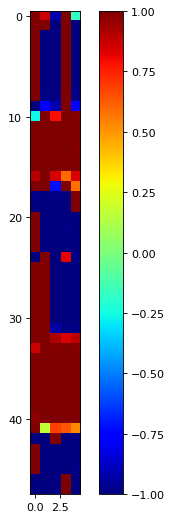

In [29]:
# actions in a 48 hour period
actions_taken = []
env.reset()
rewards = []
for hour in range(48):
    actions_taken.append(ddpg_agent.compute_action(env.observations,exploration=False))
    # actions_taken.append([0] for x in range(5))
    observations, _, done, _ = env.step(actions_taken[-1])
    reward = (UserReward(agent_count=len(observations),observation=observations).calculate()[0] - mean) / std
    rewards.append(reward)    

plt.figure(figsize=(6,8),dpi=80)
plt.imshow(np.array(actions_taken),cmap='jet',interpolation='nearest',vmin=-1,vmax=1)
plt.colorbar()

Lets analyse the critic.

It looks a normalized reward function is a bad trick to use - the environment gives off significantly worse extreme negative rewards than positive, our method introduced a implicit bias that caused the algorithm to converge to a local suboptimal solution. Should be a pretty easy optimization!

Q-value tensor([[2.1134]])


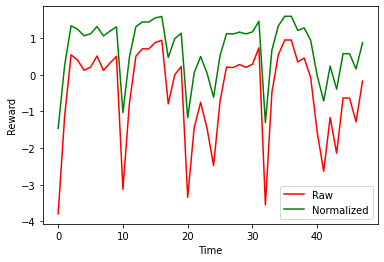

In [42]:
print("Q-value {}".format(ddpg_agent.critic.forward(torch.tensor([env.observations]).float(),torch.tensor([ddpg_agent.compute_action(env.observations)]).float())))
fig, ax = plt.subplots(1)
ax.set_xlabel("Time")
ax.set_ylabel('Reward')

raw, = plt.plot(rewards,'r-')
raw.set_label('Raw')
normalized, = plt.plot((np.array(rewards)-mean)/std,'g-')
normalized.set_label('Normalized')
ax.legend()

Something else I want to check is the communication vector used in CommNet to observe the buildings 'talking' to each other!

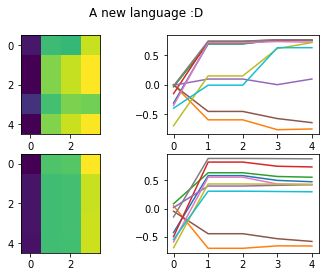

In [69]:
hidden_states = ddpg_agent.actor._in_mlp(torch.tensor(env.observations).float())
cell_states = torch.zeros(hidden_states.shape)

talk = []
hidden_states_arr = []

# Communication
for t in range(ddpg_agent.actor.comm_steps):
    # Calculate communication vectors
    comm = ddpg_agent.actor._comm_mlp(hidden_states)
    total_comm = torch.sum(comm,0)
    comm = (total_comm - comm) / (ddpg_agent.actor.agent_number-1)
    talk.append(comm)
    # Apply LSTM   
    hidden_states, cell_states = ddpg_agent.actor._lstm(comm,(hidden_states,cell_states))
    hidden_states_arr.append(hidden_states)

fig,axs = plt.subplots(2,2)
plt.suptitle("A new language :D")
axs[0][0].imshow(talk[0])
axs[1][0].imshow(talk[1])
axs[0][1].plot(hidden_states_arr[0])
axs[1][1].plot(hidden_states_arr[1])
pass


# Save and load

In [22]:
torch.save(ddpg_agent.actor.state_dict(),'models/ddpg_comm_actor.pt')
torch.save(ddpg_agent.critic.state_dict(),'models/ddpg_comm_critic.pt')

In [13]:
ddpg_agent.actor.load_state_dict(torch.load('models/ddpg_comm_actor.pt'))
ddpg_agent.critic.load_state_dict(torch.load('models/ddpg_comm_critic.pt'))

<All keys matched successfully>